# Krigging

In [1]:
from all_imports import *

import _modules

%matplotlib inline
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

from pykrige.rk import RegressionKriging

import datetime as dt

 ### test init### 


In [2]:
#TODO!
#Import and Adjust the base stuff for regression kriging
#analyse the weather station data
#How to do the krigign, check the gps data, what are the time differences

# Directory Definitions
parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirWH: str = os.path.join(parent_dir, 'Weatherdata')
dirOut: str = r'Esse\report\krigging_output'

# File Definitions
griddf    = pd.read_csv(parent_dir + '5mGrid_features_original.csv').fillna(0)
wsdf      = pd.read_csv(parent_dir + 'WS_features.csv').fillna(0)

# plttitle = 'RegressionKriging'
today = dt.datetime.now().strftime("%m%d%y-%H%M")
print(today)


#Load Files and make a feature selection
#Feature selection
terrain_features  = ['Ter_height']
sky_features      = ['Sun_h', 'Bld_SkyEx', 'Veg_SkyEx']
bld_features      = ['Bld_percent', 'Bld_height']
veg_features      = ['Veg_height', 'Veg_percent']
distance_features = ['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad',  'distToPath', 'distToCourtTrack', 'distToCarpark']

features = distance_features + sky_features   + veg_features  + bld_features + terrain_features

display(griddf.head())
display(wsdf.head())
print(features)

050424-0915


,Unnamed: 0,X,Y,id,distToTree,distToCarpark,distToCourtTrack,distToPath,distToRoad,distToWalkway,distToBuilding,Sun_h,Bld_SkyEx,Veg_SkyEx,Veg_height,Veg_percent,Bld_percent,Bld_height,Ter_height
0,0,22187.5,30692.5,77604,0.000000,63.307985,126.195950,7.390848,25.440924,23.503916,11.635957,9,63.078176,66.049332,49.424421,0.000000,0.000000,0.000000,49.424421
1,1,22187.5,30687.5,77605,0.000000,68.014909,124.831602,12.087238,21.686119,19.737900,16.420043,9,64.015580,50.917968,49.628777,0.000000,85.062123,0.000000,49.628777
2,2,22197.5,30722.5,78180,55.263466,31.693100,146.781762,5.106590,54.906503,53.416358,0.000000,0,0.000000,75.245290,43.347381,5.203222,0.000000,63.791724,43.347381
3,3,22197.5,30717.5,78181,60.041791,36.400010,144.576612,4.768805,51.022771,49.227171,0.000000,0,0.000000,75.892621,43.828036,0.000000,0.000000,63.791724,43.828036
4,4,21632.5,30382.5,45365,23.579758,65.397386,287.481258,171.065282,3.948153,53.468093,0.000000,0,0.000000,62.211868,15.752680,0.000000,0.000000,36.428059,15.752680


,X,Y,ID,distToBuilding,distToTree,distToWalkway,distToRoad,distToPath,distToCourtTrack,distToCarpark,Sun_h,Bld_SkyEx,Veg_SkyEx,Veg_height,Veg_percent,Bld_percent,Bld_height,Ter_height
0,21310.45279,31360.82993,2,1.57015,0.00008,122.30539,108.95792,1.60972,57.97288,52.28841,2,27.749220,61.427962,18.179679,0.000000,0.0,0.000000,18.179679
1,21042.23831,31242.52129,3,0.68151,0.00043,228.06879,0.00000,87.93765,267.64160,63.82834,0,0.000000,97.227844,36.956063,62.652156,0.0,48.697772,36.956063
2,21251.46471,31202.70922,4,5.49422,0.00005,243.19717,53.48967,0.13740,215.90812,24.76957,4,11.143091,84.211549,37.014219,100.000000,0.0,0.000000,37.014219
3,21210.28151,30976.03165,6,2.84506,0.00008,78.97014,0.09588,0.71531,412.98323,87.21334,10,59.374428,67.880001,31.278685,0.000000,0.0,0.000000,31.278685
4,20933.16250,30824.55084,7,9.90256,0.00002,28.08063,2.45513,34.71876,148.27183,38.57768,9,79.308154,58.324185,11.245509,0.000000,0.0,0.000000,11.245509


['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad', 'distToPath', 'distToCourtTrack', 'distToCarpark', 'Sun_h', 'Bld_SkyEx', 'Veg_SkyEx', 'Veg_height', 'Veg_percent', 'Bld_percent', 'Bld_height', 'Ter_height']


## Get the Weather Data to interpolate
This loads the feature data.
Currently Available:


1. 'Tavg' Temperature
2. 'Radavg" Radiation (not yet)
3. 'Havg' Humidity (not yet)
4. 'Wsavg' Windspeed (not yet)
5. 'Wdavg' Winddirection (not yet)



In [3]:
### Specify temperature measure to use
measure = "TAvg" # options: ['Tmax','Tavg']

### Read and prepare weather data
df = pd.read_csv(dirWH + '/' + measure +'.csv')
df = df.merge(wsdf[["X","Y",'ID']], on='ID', how='left')

### Get min and max value for plotting graph
minval = df.drop(columns=['ID','Lat','Long','X','Y']).min(numeric_only=True).min()
maxval = df.drop(columns=['ID','Lat','Long','X','Y']).max(numeric_only=True).max()
print("Min: ", minval, "Max: ",maxval)

display(df)

Min:  29.16210526 Max:  31.85569444


,ID,Lat,Long,Feb-19,Mar-19,Apr-19,May-19,Jun-19,Jul-19,Aug-19,Sep-19,Oct-19,Nov-19,Dec-19,Jan-20,Feb-20,Mar-20,Apr-20,X,Y
0,2,103.773209,1.299893,30.526873,30.876590,30.668614,30.360756,30.517382,30.681760,30.831790,30.785633,30.716708,30.668802,29.853832,30.254592,30.256062,30.779533,31.202580,21310.45279,31360.82993
1,3,103.770795,1.298818,30.731417,30.941410,30.870204,30.453041,30.584513,30.783065,30.914491,30.863537,30.727251,30.683038,30.084292,30.595241,30.911779,31.301049,31.855694,21042.23831,31242.52129
2,4,103.772678,1.298462,29.828103,30.311227,30.246330,30.066304,30.194167,30.398797,30.491415,30.186056,30.079038,29.974144,29.162105,29.293864,29.380810,30.169184,30.853038,21251.46471,31202.70922
3,6,103.772312,1.296408,30.323751,30.802500,30.926387,30.709679,30.764784,31.173207,31.258762,31.028396,30.887817,30.700101,29.764139,29.921572,29.903398,30.700197,31.301715,21210.28151,30976.03165
4,7,103.769825,1.295043,30.893403,31.133035,30.871306,30.563252,30.799470,31.033504,31.150929,31.126579,30.901208,30.813653,30.123023,30.604192,30.665292,31.139361,31.339160,20933.16250,30824.55084
5,8,103.772115,1.295015,30.263053,30.694899,30.537026,30.100151,30.295245,30.420757,30.480579,30.430489,30.424304,30.286940,29.676045,30.125686,30.305479,30.841523,31.357301,21188.01955,30822.33307
6,11,103.772713,1.297254,30.700886,30.999372,30.516116,29.939751,30.199161,30.176747,30.355032,30.371883,30.412861,30.461578,30.092886,30.816228,31.047495,31.246667,31.558588,21254.80024,31068.91350
7,12,103.778576,1.292662,30.036935,30.322834,30.122826,29.891583,30.034022,30.268080,30.657104,30.552792,30.256237,30.151797,29.360618,29.766269,29.831355,30.281404,30.739513,21908.06866,30561.35985
8,13,103.780762,1.291102,30.616987,31.001205,31.437091,31.272272,31.278205,31.682927,31.609210,31.392144,31.381069,31.147191,29.955685,29.998275,30.019161,30.885134,31.754292,22150.68034,30388.85790
9,16,103.781166,1.294635,29.770080,30.295118,30.273482,29.813045,29.848863,30.142185,30.234552,30.124773,30.081310,30.316355,29.229381,29.521815,29.618192,30.213448,30.634596,22196.31786,30779.18631


# Clustering

In [ ]:
metadatadf = griddf.copy()

# Quantization function
def quantize_column(column, step_size):
    return round(column / step_size) * step_size

# Number of steps for quantization
num_steps = 3

feature_list = ['Bld_percent', 'distToBuilding', 'Bld_height', 'Veg_height', 'distToTree']


# Determine step sizes for each column and apply quantization
for col in feature_list:
    step_size = metadatadf[col].max() / num_steps
    metadatadf[f'quantized_{col}'] = metadatadf[col].apply(quantize_column, args=(step_size,))

# Standard scaling
scaler = StandardScaler()
metadatadf[feature_list] = scaler.fit_transform(metadatadf[feature_list])

# KMeans clustering
n_clusters = 10
metadatadf['cluster'] = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(metadatadf[feature_list])

# Plot the clustered data
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='rainbow', s=1, marker='s')
plt.title('Clustered Data')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.colorbar(label='Cluster')
plt.show()
#-------------------------------------------------------------------------------------------------
# DBSCAN clustering
X = metadatadf[['cluster', 'X', 'Y']] #features for DBclustering
X_scaled = StandardScaler().fit_transform(X)

eps = 0.35
min_samples = 250
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
metadatadf['cluster'] = dbscan.fit_predict(X_scaled)

# Visualize the DBSCAN clustering
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='hsv', s=1, marker='s')
plt.colorbar(label='Cluster')
plt.title('DBSCAN Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#-------------------------------------------------------------------------------------------------
#downsampling and upscaling again
# Group by the cluster column
metadata_df_grp = metadatadf.groupby('cluster')

# Define a function to sample a specific percentage from each group
def downsample_group(group):
    return group.sample(frac=0.25)  # You can adjust the fraction as needed

# Apply the downsampling function to each group
downsampled_df = metadata_df_grp.apply(downsample_group)

# Reset the index of the downsampled DataFrame
downsampled_df.reset_index(drop=True, inplace=True)

plt.scatter(downsampled_df['X'], downsampled_df['Y'], c=downsampled_df['cluster'], cmap='hsv', alpha=0.7,  s=5, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Downsampled Scatter Plot')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

# Fit Nearest Neighbors model on the downsampled data
nn_model = NearestNeighbors(n_neighbors=1).fit(downsampled_df[['X', 'Y']])

# Find the index of the nearest neighbor for each point in griddf
distances, indices = nn_model.kneighbors(griddf[['X', 'Y']])

# Map the cluster values from downsampled_df to griddf based on the nearest neighbors
griddf['cluster'] = downsampled_df.loc[indices.flatten()]['cluster'].values

plt.scatter(griddf['X'], griddf['Y'], c=griddf['cluster'], cmap='viridis', alpha=0.7,  s=1, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot with Cluster Test')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

#-------------------------------------------------------------------------------------------------
#Somehow smooth the data..



#-------------------------------------------------------------------------------------------------
#adjusting the considered features
quantized_cols = metadatadf.filter(like='quantized').columns
# griddf = metadatadf.drop(columns=quantized_cols) #.drop(columns=['cluster_x', 'cluster_y'])

features.append('cluster')

### get features for wsdf
# Calculating distances using sklearn's NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(griddf[['X', 'Y']])
distances, indices = nbrs.kneighbors(wsdf[['X', 'Y']])
# Add the index of the closest point in griddf to wsdf
wsdf['closest_index'] = indices.flatten()
# Retrieve specific columns from griddf based on closest_index and merge it with wsdf and only new selection features
merged_data = wsdf.join(griddf['cluster'], on='closest_index') #rsuffix='_griddf')
# Drop the redundant 'closest_index' column
wsdf = merged_data.drop(columns=['closest_index'])


# Print the updated list
print(features)

#display(griddf)


# Regression Kriging

Feb-19
Finished learning regression model
Finished kriging residuals


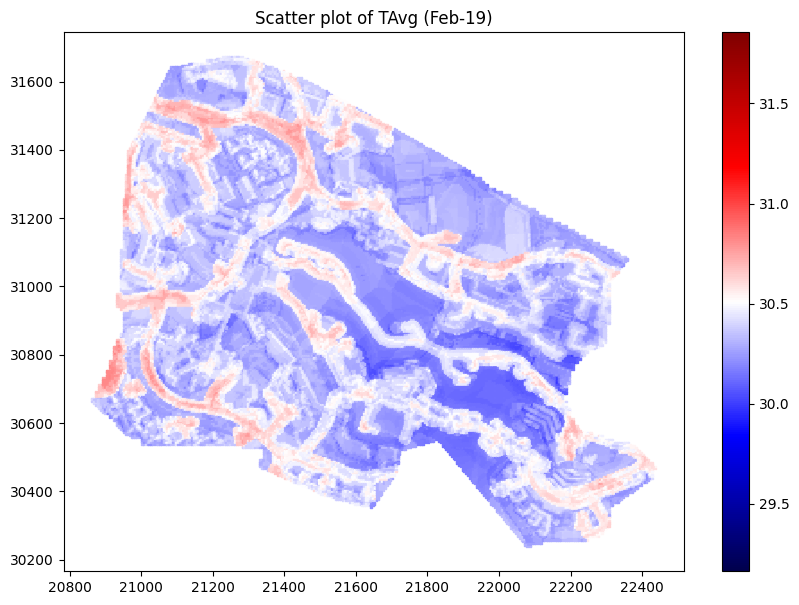

In [6]:
### Select features for model
p = wsdf[features]
target_p = griddf[features]
target_x = np.array(list(zip(griddf.X, griddf.Y)))

feature_importance_df = pd.DataFrame(features, columns =['FeatureName'])

### SVR model parameters
C = 0.0005
gamma = 5
kernel = ['linear'] # options: ['#linear', 'poly', 'rbf', 'sigmoid']

### RandomForestRegressor parameters
n_estimators=50
random_state=4

### RegressionKrigging parameters
n = 8
variogram_models = ['spherical'] # options: ["linear", "power", "gaussian", "spherical", "exponential"]

### List of month names
months = ["Feb-19"] # "Mar-19","Apr-19","May-19","Jun-19","Jul-19","Aug-19","Sep-19","Oct-19","Nov-19","Dec-19","Jan-20","Feb-20","Mar-20","Apr-20"


for k in variogram_models:
    model = RandomForestRegressor(n_estimators=15, random_state=random_state)

    scores_mths = []
    for mth in months:
        print(mth)

        x = np.array(list(zip(wsdf.X, wsdf.Y)))
        target = np.array(df[mth])

        print("=" * 40)
        m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=k, verbose=False)

        m_rk.fit(p, x, target)
        result = m_rk.predict(target_p, target_x)
        resultdf = griddf
        resultdf[measure] = result

        ### Plot map (uncomment and adjust vmin, vmax and ticks if needed)
        plt.figure(figsize=(10, 7))
        plt.scatter(resultdf['X'], resultdf['Y'], c=resultdf[measure], cmap='seismic', marker='s', s=1, vmin=minval, vmax=maxval)
        plt.title('Scatter plot of '+ measure +' (' + mth + ')')
        cbar = plt.colorbar()
        # ticks = [14.0,16.5,19.0,21.5,24.0,26.5,29.0,31.5]
        # cbar.set_ticks(ticks)
        # cbar.set_ticklabels(ticks)

        ### Print results to csv per month (uncomment to save csv and png)
        if not os.path.exists(dirOut + today):
          os.makedirs(dirOut + today)
        resultdf.to_csv(dirOut + today + '/' + measure + mth + '.csv')
        plt.savefig(dirOut + today + '/' + measure + mth + '.png', bbox_inches='tight')
        plt.show()

        ### Extract feature importances (uncomment to display feature importances)
        feature_importance_df[mth] = m_rk.regression_model.feature_importances_
        # featuredf = pd.DataFrame(list(zip(m_rk.regression_model.feature_names_in_, m_rk.regression_model.feature_importances_)), columns =['FeatureName', 'FeatureImportance'])
        # display(featuredf.sort_values(by=['FeatureImportance'], ascending=False))

# Feature Importance

In [ ]:
feature_importance_df = feature_importance_df.assign(mean=feature_importance_df.mean(axis=1))

feature_plotheatmap = feature_importance_df.sort_values(by=['mean'], ascending=False)
feature_plotheatmap = feature_plotheatmap.set_index('FeatureName')

plt.figure(figsize=(10, 6))
sns.heatmap(feature_plotheatmap, annot=True, cmap='coolwarm')
plt.title('Feature Importance Heatmap')
plt.xlabel('Models')
plt.ylabel('Features')
plt.show()

# plt.savefig(dirRP + today + '/' + 'FeatureMap' + '_' + measure + mth + '.png', bbox_inches='tight')

#select features based on threshhold
treshhold = 0.025
update_feature_selection = feature_plotheatmap[feature_plotheatmap['mean'] > treshhold].index.tolist()
print(update_feature_selection)